In [1]:
# ! pip install rosbags

In [2]:
import sys
import numpy as np

_DATATYPES = {}
# _DATATYPES[PointField.INT8] = np.dtype(np.int8)
# _DATATYPES[PointField.UINT8] = np.dtype(np.uint8)
# _DATATYPES[PointField.INT16] = np.dtype(np.int16)
_DATATYPES[4] = np.dtype(np.uint16)
# _DATATYPES[PointField.INT32] = np.dtype(np.int32)
# _DATATYPES[PointField.UINT32] = np.dtype(np.uint32)
_DATATYPES[7] = np.dtype(np.float32)
# _DATATYPES[PointField.FLOAT64] = np.dtype(np.float64)


def dtype_from_fields(fields, point_step = None) -> np.dtype:
    """
    Convert a Iterable of sensor_msgs.msg.PointField messages to a np.dtype.

    :param fields: The point cloud fields.
                   (Type: iterable of sensor_msgs.msg.PointField)
    :param point_step: Point step size in bytes. Calculated from the given fields by default.
                       (Type: optional of integer)
    :returns: NumPy datatype
    """
    # Create a lists containing the names, offsets and datatypes of all fields
    field_names = []
    field_offsets = []
    field_datatypes = []
    for i, field in enumerate(fields):
        # Datatype as numpy datatype
        datatype = _DATATYPES[field.datatype]
        # Name field
        if field.name == '':
            name = f'unknown_field_{i}'
        else:
            name = field.name
        # Handle fields with count > 1 by creating subfields with a suffix consiting
        # of "_" followed by the subfield counter [0 -> (count - 1)]
        assert field.count > 0, "Can't process fields with count = 0."
        for a in range(field.count):
            # Add suffix if we have multiple subfields
            if field.count > 1:
                subfield_name = f'{name}_{a}'
            else:
                subfield_name = name
            assert subfield_name not in field_names, 'Duplicate field names are not allowed!'
            field_names.append(subfield_name)
            # Create new offset that includes subfields
            field_offsets.append(field.offset + a * datatype.itemsize)
            field_datatypes.append(datatype.str)

    # Create dtype
    dtype_dict = {
            'names': field_names,
            'formats': field_datatypes,
            'offsets': field_offsets
    }
    if point_step is not None:
        dtype_dict['itemsize'] = point_step
    return np.dtype(dtype_dict)

def read_points(
        cloud,
        field_names = None,
        skip_nans = False,
        uvs = None,
        reshape_organized_cloud = False) -> np.ndarray:
    """
    Read points from a sensor_msgs.PointCloud2 message.

    :param cloud: The point cloud to read from sensor_msgs.PointCloud2.
    :param field_names: The names of fields to read. If None, read all fields.
                        (Type: Iterable, Default: None)
    :param skip_nans: If True, then don't return any point with a NaN value.
                      (Type: Bool, Default: False)
    :param uvs: If specified, then only return the points at the given
        coordinates. (Type: Iterable, Default: None)
    :param reshape_organized_cloud: Returns the array as an 2D organized point cloud if set.
    :return: Structured NumPy array containing all points.
    """


    # Cast bytes to numpy array
    points = np.ndarray(
        shape=(cloud.width * cloud.height, ),
        dtype=dtype_from_fields(cloud.fields, point_step=cloud.point_step),
        buffer=cloud.data)

    # Keep only the requested fields
    if field_names is not None:
        assert all(field_name in points.dtype.names for field_name in field_names), \
            'Requests field is not in the fields of the PointCloud!'
        # Mask fields
        points = points[list(field_names)]

    # Swap array if byte order does not match
    if bool(sys.byteorder != 'little') != bool(cloud.is_bigendian):
        points = points.byteswap(inplace=True)

    # Check if we want to drop points with nan values
    if skip_nans and not cloud.is_dense:
        # Init mask which selects all points
        not_nan_mask = np.ones(len(points), dtype=bool)
        for field_name in points.dtype.names:
            # Only keep points without any non values in the mask
            not_nan_mask = np.logical_and(
                not_nan_mask, ~np.isnan(points[field_name]))
        # Select these points
        points = points[not_nan_mask]

    # Select points indexed by the uvs field
    if uvs is not None:
        # Don't convert to numpy array if it is already one
        if not isinstance(uvs, np.ndarray):
            uvs = np.fromiter(uvs, int)
        # Index requested points
        points = points[uvs]

    # Cast into 2d array if cloud is 'organized'
    if reshape_organized_cloud and cloud.height > 1:
        points = points.reshape(cloud.width, cloud.height)

    return points

In [3]:
import os
import boto3
import json
import sagemaker
from pathlib import Path
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name


# Read in the notebook parameters file
with open ('/home/ec2-user/SageMaker/global-resources/notebook-params.json', 'r') as fh:
    input_data = fh.read()
    sagemaker_parameters = json.loads(input_data)

# Set variables for SageMaker API requests
data_bucket = sagemaker_parameters['pSMSDataBucketName']
subnets = sagemaker_parameters['pSMSSubnetIds'].split(',')
kms_cmk = sagemaker_parameters['pSMSKMSKeyId']
sg_id = sagemaker_parameters['pSMSSecurityGroupId']


# Set the user and project variables
log_path = '/opt/ml/metadata/resource-metadata.json'
with open(log_path, 'r') as logs:
   _logs = json.load(logs)

project = _logs['ResourceName'].split('-')[0]
user = _logs['ResourceName'].split('-')[1]


# Set the tags to associate with SageMaker API calls
tags = [
    {
        "Key": "project",
        "Value": project
    },
    {
        "Key": "system",
        "Value": "MLSpace"
    },
    {
        "Key": "user",
        "Value": user
    }
]

project_prefix = 'project/' + project + '/datasets'
vpc_config = {
    "SecurityGroupIds": sg_id,
    "Subnets": subnets
}


# Download one of the dataset files to the notebook

# s3 = boto3.client("s3")
# dataset_path = "global/datasets/TRBChallengeData"
# s3.download_file(data_bucket, f"{dataset_path}/2023-11-03-12-37-20.bag", "2023-11-03-12-37-20.bag")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [8]:
from rosbags.highlevel import AnyReader

# create reader instance and open for reading

def read_point_clouds(num_msgs=10):
    points = []
    pxyzs = []
    ct = 0
    with AnyReader([Path("./2023-11-03-12-37-20.bag")]) as reader:
        connections = [x for x in reader.connections if x.topic == "/lidar_0000/pandar"]
        for connection, timestamp, rawdata in reader.messages(connections=connections):
            msg = reader.deserialize(rawdata, connection.msgtype)
            pt = read_points(msg)            
            pt_xyz = np.vstack([[p[0], p[1], p[2]] for p in pt])
            points.append(pt)
            pxyzs.append(pt_xyz)
            ct += 1            
            if ct >= num_msgs:
                return points, pxyzs, msg
    return None

points, pxyzs, msg = read_point_clouds(10)



In [16]:
points

[array([( 0.        , 0.17773035,  0.0476227 , 2.,  0),
        ( 0.        , 0.16300969,  0.04064288, 2.,  1),
        ( 0.        , 0.17538661,  0.04049119, 2.,  2), ...,
        (-0.00046335, 0.14748423, -0.03677213, 2., 29),
        (-0.00046127, 0.14682   , -0.0393405 , 3., 30),
        (-0.00050736, 0.16149117, -0.04630708, 6., 31)],
       dtype={'names': ['x', 'y', 'z', 'intensity', 'ring'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<u2'], 'offsets': [0, 4, 8, 16, 20], 'itemsize': 32}),
 array([( 0.        , 0.13136591,  0.03519939, 3.,  0),
        ( 0.        , 0.1591285 ,  0.03967519, 2.,  1),
        ( 0.        , 0.15589921,  0.03599217, 2.,  2), ...,
        (-0.00047555, 0.15136538, -0.03773982, 2., 29),
        (-0.00046127, 0.14682   , -0.0393405 , 3., 30),
        (-0.00055568, 0.17687127, -0.05071728, 6., 31)],
       dtype={'names': ['x', 'y', 'z', 'intensity', 'ring'], 'formats': ['<f4', '<f4', '<f4', '<f4', '<u2'], 'offsets': [0, 4, 8, 16, 20], 'itemsize': 32}),
 a

In [12]:
from datetime import datetime


In [15]:
dt_object = datetime.fromtimestamp(msg.header.stamp.sec)
print("dt_object =", dt_object)

dt_object = 2023-11-03 16:37:22


In [11]:
msg.header.stamp.sec

builtin_interfaces__msg__Time(sec=1699029442, nanosec=82382000, __msgtype__='builtin_interfaces/msg/Time')

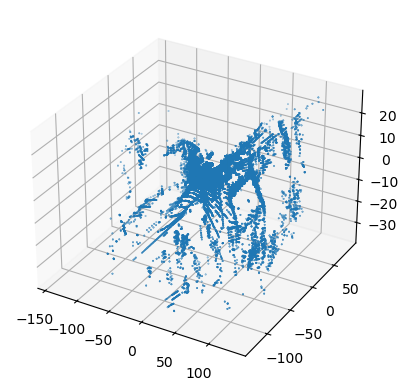

In [7]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ps_xyz = pxyzs[4]
ax.scatter(ps_xyz[:,0], ps_xyz[:,1], ps_xyz[:,2],s=0.1)


In [6]:
asdfwf

NameError: name 'asdfwf' is not defined

In [ ]:
import bagpy
from bagpy import bagreader

In [ ]:
bag = bagreader("./2023-11-03-12-37-20.bag")

In [ ]:
bag.topic_table